In [1]:
import sys

In [2]:
from IPython.display import display, Markdown
import numpy as np
import pandas as pd
import sklearn.cluster
import sklearn.decomposition
import sklearn.linear_model
import sklearn.metrics
import sklearn.model_selection
import xarray as xr

In [3]:
sys.path.append('../src/lib/')
import plot

## Load Data ##

In [4]:
sfa = xr.open_dataset('../models/sfa.nc')
display(sfa)

<xarray.Dataset>
Dimensions:  (factor: 10, patient: 304)
Coordinates:
  * factor   (factor) object 'Factor 1' 'Factor 2' 'Factor 3' 'Factor 4' ...
  * patient  (patient) int64 1237 976 1382 480 1016 630 636 859 196 367 1861 ...
Data variables:
    factors  (factor, patient) float64 -0.2269 1.02 -0.4513 -0.1683 -0.7058 ...

In [5]:
sfa['names'] = ('factor', [
    'ER',
    'EMT',
    'Luminal Proliferative',
    'Technical RNA-seq',
    'Technical RPPA',
    'Immune',
    'HER2',
    'Normal-like / ILC',
    'TN Proliverative',
    'Chr8'
])

In [6]:
mri = xr.open_dataset('../data/processed/mri-features.nc')
assert all(mri['patient'] == sfa['patient'])
display(mri)

<xarray.Dataset>
Dimensions:                              (patient: 304)
Coordinates:
  * patient                              (patient) int64 192 196 199 204 207 ...
Data variables:
    Comment                              (patient) object '' '' '' ...
    MultiFocal                           (patient) float64 0.0 0.0 0.0 0.0 ...
    circularity                          (patient) float64 0.8344 0.7081 ...
    irregularity                         (patient) float64 0.4046 0.5653 ...
    volume                               (patient) float64 784.6 1.351e+04 ...
    largest_diameter                     (patient) float64 15.07 44.05 29.68 ...
    mean_vox_val                         (patient) float64 109.0 67.0 64.0 ...
    variance_vox_val                     (patient) float64 1.364e+03 502.0 ...
    uptake_speed                         (patient) float64 0.9821 1.802 ...
    washout                              (patient) float64 0.1572 0.162 ...
    ser                                  (p

In [7]:
clin = pd.read_table('../data/raw/imagene_clinical.tsv')
clin = clin.set_index('margins_patient')
clin.index.name = 'patient'
clin = clin.to_xarray()
clin = clin.loc[{'patient': sfa.patient}]
assert(np.all(clin.patient == sfa.patient))
display(clin)

<xarray.Dataset>
Dimensions:               (patient: 304)
Coordinates:
  * patient               (patient) int64 1237 976 1382 480 1016 630 636 859 ...
Data variables:
    rna_sample            (patient) object 'CF5171' 'CF5088' 'CF5198' ...
    pos_LN                (patient) float64 0.0 1.0 0.0 1.0 1.0 1.0 1.0 0.0 ...
    largest_diameter_MRI  (patient) float64 18.0 54.0 30.0 25.0 32.0 23.0 ...
    histograde            (patient) float64 3.0 3.0 3.0 3.0 2.0 2.0 1.0 3.0 ...
    age_at_diag           (patient) float64 72.62 66.34 59.5 54.86 31.0 ...
    ihc_subtype           (patient) object 'ER+/HER2-' 'HER2+' 'ER+/HER2-' ...
    AdjRT                 (patient) object 'T' 'T' 'T' 'T' 'F' 'T' 'T' 'T' ...
    AdjChemo              (patient) object 'F' 'F' 'F' 'T' 'T' 'F' 'F' 'F' ...
    AdjHormo              (patient) object 'F' 'T' 'T' 'T' 'T' 'T' 'F' 'T' ...
    AdjAntiHER2           (patient) object 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' ...
    AdjSystemic           (patient) object 'F' 'T

Select samples with no missing values for MRI features.

In [8]:
mri_features = list(set(mri.keys()) - {'patient', 'Comment', 'MultiFocal'})
mri_array = mri[mri_features].to_array()
assert(mri_array.dtype == np.float64)
ihc_idx = np.array([t in ['ER+/HER2-', 'TN'] for t in clin['ihc_subtype']])
sel_samples = mri_array['patient'][(np.isnan(mri_array).sum('variable') == 0) & ihc_idx]
mri_array = mri_array.reindex(patient=sel_samples).transpose('patient', 'variable')

## Supporting Functions ##

In [9]:
def plot_roc(y, y_pred):
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(y, y_pred)
    auc = sklearn.metrics.auc(fpr, tpr)
    with plot.subplots(1, 1) as (fig, ax):
        ax.plot(fpr, tpr)
        ax.plot([0, 1], [0, 1], color='black', linestyle='--')
        ax.set_title("AUC = {}".format(auc))

In [10]:
def bin_performance(y, y_pred):
    if y_pred.dtype != np.bool:
        y_pred = y_pred > 0.5
    
    return dict({
        'Accuracy': np.mean(y == y_pred),
        'Sensitivity': np.sum(y & y_pred) / np.sum(y),
        'Specificity': np.sum(~y & ~y_pred) / np.sum(~y),
        'Precision': np.sum(y & y_pred) / np.sum(y_pred)
    })

# Predict Clinical #

In [11]:
X = mri_array.values
y = clin['ihc_subtype'].reindex(patient=sel_samples).values == 'ER+/HER2-'

Null model

In [12]:
display(bin_performance(y, np.ones(len(y))))

{'Accuracy': 0.7865612648221344,
 'Precision': 0.7865612648221344,
 'Sensitivity': 1.0,
 'Specificity': 0.0}

In [13]:
class PcaLog():
    
    def __init__(self, n_components=18):
        self.n_components = n_components

    def train(self, X, y):

        self._pca = sklearn.decomposition.PCA(self.n_components)
        X_pc = self._pca.fit_transform(X)

        self._logm = sklearn.linear_model.LogisticRegression()
        self._logm.fit(X_pc, y)
        
    def predict(self, X):
        X_pc = self._pca.transform(X)
        return self._logm.predict_proba(X_pc)[:, 1]

{'Accuracy': 0.80632411067193677,
 'Precision': 0.81779661016949157,
 'Sensitivity': 0.96984924623115576,
 'Specificity': 0.20370370370370369}

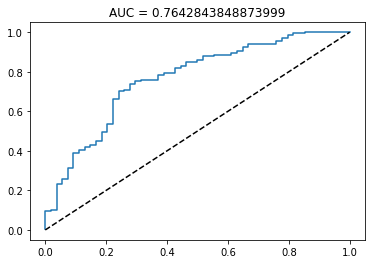

In [14]:
model = PcaLog()
model.train(X, y)
y_pred = model.predict(X)
display(bin_performance(y, y_pred))
plot_roc(y, y_pred)

{'Accuracy': 0.7865612648221344,
 'Precision': 0.81385281385281383,
 'Sensitivity': 0.94472361809045224,
 'Specificity': 0.20370370370370369}

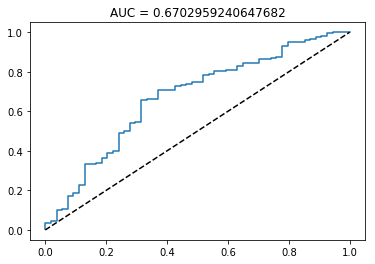

In [15]:
loocv = sklearn.model_selection.LeaveOneOut()
y_pred = np.full(y.shape, np.nan)
for train_index, test_index in loocv.split(X):
    m = PcaLog()
    m.train(X[train_index, :], y[train_index])
    y_pred[test_index] = m.predict(X[test_index, :])
display(bin_performance(y, y_pred))
plot_roc(y, y_pred)

# Predict Factors #

## Linear Regression ##

In [16]:
X = mri_array.values 
y = sfa['factors'].reindex(patient=sel_samples).transpose('patient', 'factor').values
y = (y - np.mean(y, 0, keepdims=True)) / np.std(y, 0, keepdims=True)

In [17]:
def mse_performance(y, y_pred):
    if y_pred.dtype != np.bool:
        y_pred = y_pred > 0.5
    
    return dict({
        'MSE': np.mean((y - y_pred)**2)
    })

In [18]:
n_components = 18

class PcaLin():
    
    def __init__(self, n_components=18):
        self.n_components = n_components

    def train(self, X, y):

        self._pca = sklearn.decomposition.PCA(self.n_components)
        X_pc = self._pca.fit_transform(X)

        self._lm = sklearn.linear_model.LinearRegression()
        self._lm.fit(X_pc, y)
        
    def predict(self, X):
        X_pc = self._pca.transform(X)
        return self._lm.predict(X_pc)

##### Factor ER 

{'MSE': 0.93924158143618575}

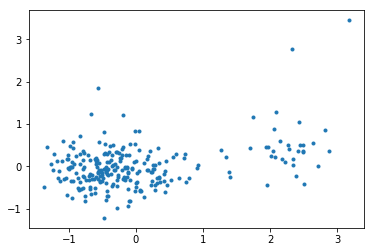

##### Factor EMT 

{'MSE': 1.0297364404801188}

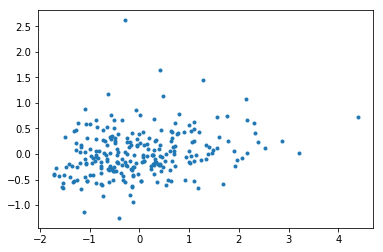

##### Factor Luminal Proliferative 

{'MSE': 0.95678395439999864}

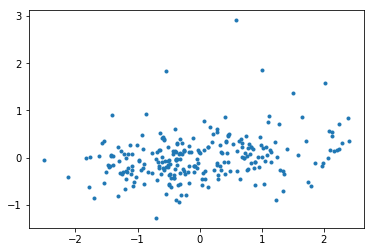

##### Factor Technical RNA-seq 

{'MSE': 0.98151441891636815}

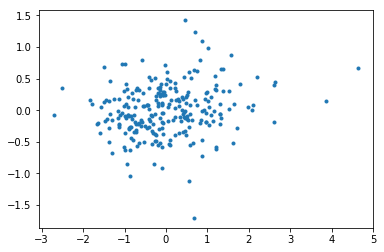

##### Factor Technical RPPA 

{'MSE': 1.0348407041469678}

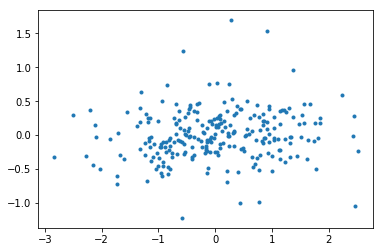

##### Factor Immune 

{'MSE': 1.0192776030499722}

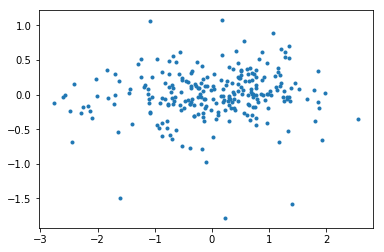

##### Factor HER2 

{'MSE': 1.0539313648396045}

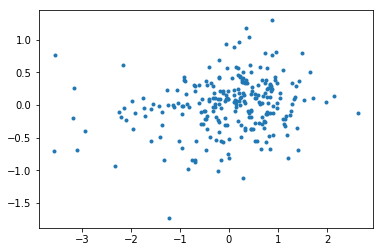

##### Factor Normal-like / ILC 

{'MSE': 0.9088141227182881}

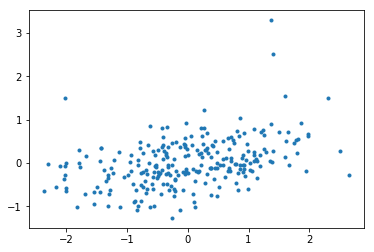

##### Factor TN Proliverative 

{'MSE': 1.0647596936242238}

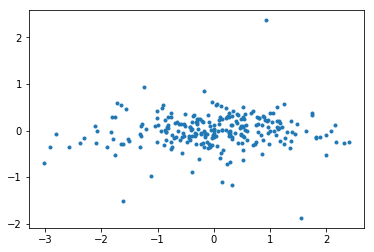

##### Factor Chr8 

{'MSE': 1.0361800337610074}

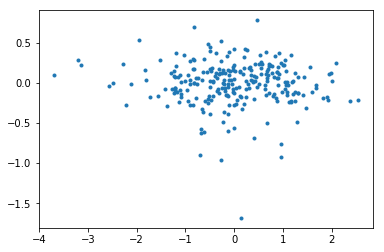

In [19]:
for factor_i in range(y.shape[1]):
    loocv = sklearn.model_selection.LeaveOneOut()
    y_pred = np.full(y.shape[0], np.nan)
    for train_index, test_index in loocv.split(X):
        m = PcaLin()
        m.train(X[train_index, :], y[train_index, factor_i])
        y_pred[test_index] = m.predict(X[test_index, :])
    display(Markdown("##### Factor {} ".format(sfa['names'][factor_i].item())))
    display(mse_performance(y[:, factor_i], y_pred))
    with plot.subplots(1, 1) as (fig, ax):
        ax.plot(y[:, factor_i], y_pred, '.')  

## Logistic Regression ##

In [20]:
X = mri_array.values 
y_real = sfa['factors'].reindex(patient=sel_samples).transpose('patient', 'factor').values
y = np.zeros(y_real.shape, dtype=np.bool)
for factor_i in range(y.shape[1]):
    kmeans = sklearn.cluster.KMeans(2)
    kmeans.fit(y_real[:, [factor_i]])
    y[:, factor_i] = np.array(kmeans.labels_ == 1)

##### Factor ER 

{'Accuracy': 0.85770750988142297,
 'Precision': 0.52631578947368418,
 'Sensitivity': 0.27027027027027029,
 'Specificity': 0.95833333333333337}

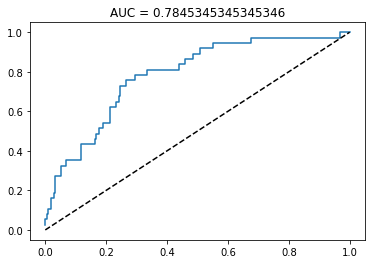

##### Factor EMT 

{'Accuracy': 0.59288537549407117,
 'Precision': 0.46031746031746029,
 'Sensitivity': 0.29591836734693877,
 'Specificity': 0.78064516129032258}

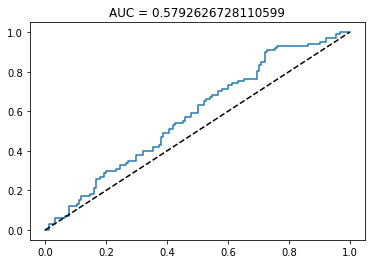

##### Factor Luminal Proliferative 

{'Accuracy': 0.66798418972332019,
 'Precision': 0.61111111111111116,
 'Sensitivity': 0.44,
 'Specificity': 0.81699346405228757}

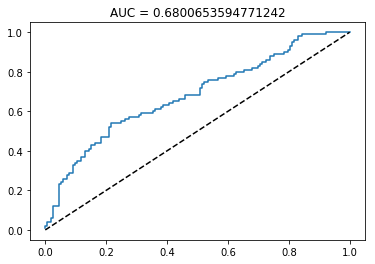

##### Factor Technical RNA-seq 

{'Accuracy': 0.5731225296442688,
 'Precision': 0.4375,
 'Sensitivity': 0.28000000000000003,
 'Specificity': 0.76470588235294112}

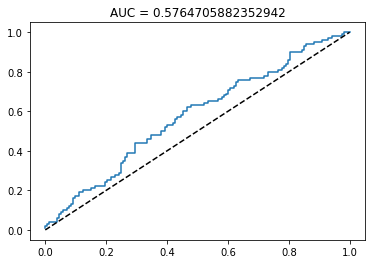

##### Factor Technical RPPA 

{'Accuracy': 0.56916996047430835,
 'Precision': 0.59162303664921467,
 'Sensitivity': 0.78472222222222221,
 'Specificity': 0.28440366972477066}

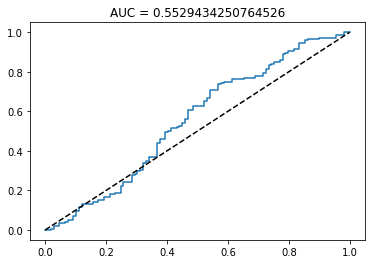

##### Factor Immune 

{'Accuracy': 0.59683794466403162,
 'Precision': 0.60784313725490191,
 'Sensitivity': 0.68888888888888888,
 'Specificity': 0.49152542372881358}

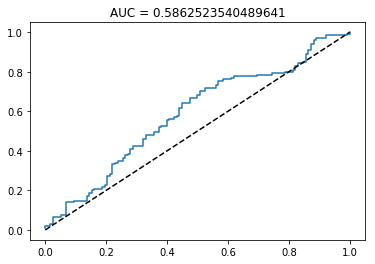

##### Factor HER2 

{'Accuracy': 0.72332015810276684,
 'Precision': 0.51428571428571423,
 'Sensitivity': 0.25352112676056338,
 'Specificity': 0.90659340659340659}

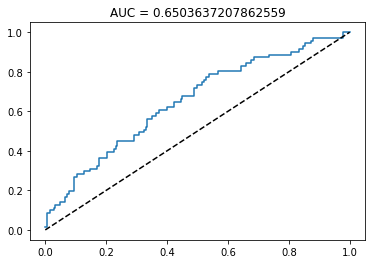

##### Factor Normal-like / ILC 

{'Accuracy': 0.61660079051383399,
 'Precision': 0.62411347517730498,
 'Sensitivity': 0.66666666666666663,
 'Specificity': 0.56198347107438018}

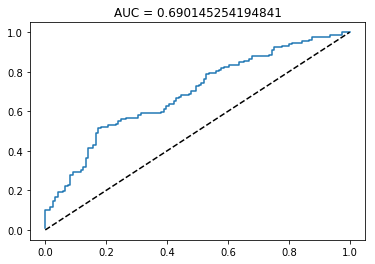

##### Factor TN Proliverative 

{'Accuracy': 0.5731225296442688,
 'Precision': 0.59876543209876543,
 'Sensitivity': 0.69285714285714284,
 'Specificity': 0.4247787610619469}

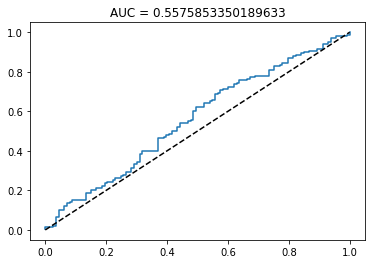

##### Factor Chr8 

{'Accuracy': 0.47826086956521741,
 'Precision': 0.51249999999999996,
 'Sensitivity': 0.6029411764705882,
 'Specificity': 0.33333333333333331}

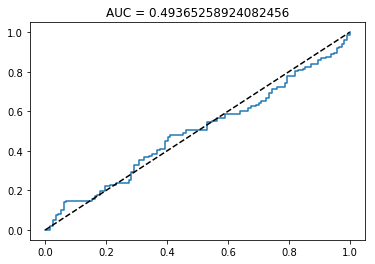

In [21]:
for factor_i in range(y.shape[1]):
    loocv = sklearn.model_selection.LeaveOneOut()
    y_pred = np.full(y.shape[0], np.nan)
    for train_index, test_index in loocv.split(X):
        m = PcaLog()
        m.train(X[train_index, :], y[train_index, factor_i])
        y_pred[test_index] = m.predict(X[test_index, :])
    display(Markdown("##### Factor {} ".format(sfa['names'][factor_i].item())))
    display(bin_performance(y[:, factor_i], y_pred))
    plot_roc(y[:, factor_i], y_pred)